# Критические сети и бета-устойчивые уровни

Код по мотивам статьи https://users.cs.duke.edu/~tomasi/papers/gu/guEccv10.pdf:

`Gu, Steve, Ying Zheng, and Carlo Tomasi. "Critical nets and beta-stable features for image matching." European Conference on Computer Vision. Springer Berlin Heidelberg, 2010`

Строится пирамида изображений из последовательных приближений лапласиана: $L_k \approx J_{k+1} - J_k = G_{\sqrt{k+1}\sigma}*I - G_{\sqrt{k}\sigma}*I$. Далее для каждого изображения $L^+_k = L_k > 0$ (содержащего максимально выпуклые области) считается число компонент связности. Уровень $k$ называется $\beta$-устойчивым уровнем, если число компонент связности в $L^+_{\xi}$ при каждом $\xi \in [k - \beta; k)$ одинаково.

Далее для бета-устойчивого уровня считаются экстремумы (по сути это особые точки SIFT), на которых потом строится граф.

# Исходное изображение

In [1]:
import importlib as imp
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN

import cnet

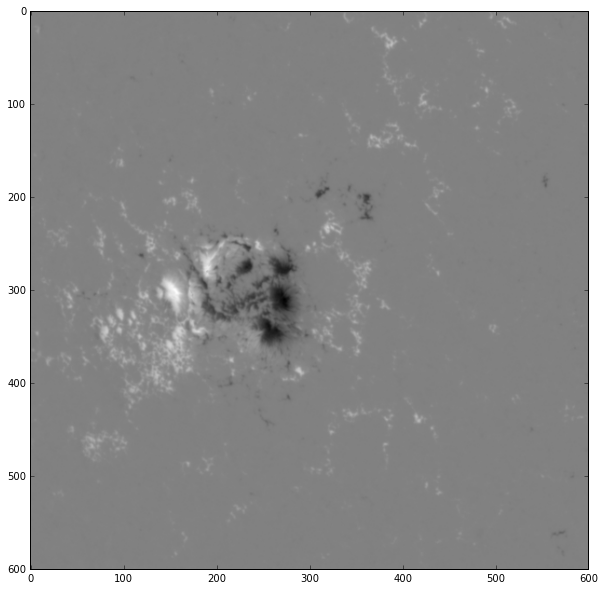

In [2]:
filepath = 'images/hmi.M_720s.20110729_170000_TAI.1.magnetogram.png'
img = io.imread(filepath)
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.show()

# $\beta$-устойчивые масштабы

Для каждого изображения из пирамиды ищем такое наименьшее $k$ и такое число $\beta$, что число компонент связаности при масштабе $s \in [k-\beta; k)$, не меняется. Таких $\beta$, естественно, может быть найдено несколько.

In [3]:
log, components, beta_scales, betas = cnet.cpt_stable_log(filepath, ss_sigma=1.6)
print(list(zip(beta_scales, betas)))

[(13, 2), (19, 2), (21, 2), (38, 4), (41, 3), (44, 3), (47, 3), (50, 2), (53, 2), (60, 5), (65, 5), (68, 2), (99, 31)]


## График количества компонент связности бинаризованных лапласианов в зависимости от масштаба

Под масштабом здесь понимается индекс $k$: $s = 1.6k$.

In [4]:
print(components)

[350, 201, 143, 123, 105, 91, 76, 64, 60, 52, 50, 49, 40, 40, 31, 30, 25, 24, 25, 25, 27, 27, 29, 31, 29, 28, 29, 28, 30, 31, 28, 25, 23, 21, 19, 18, 18, 18, 18, 17, 17, 17, 16, 16, 16, 14, 14, 14, 13, 12, 12, 13, 11, 11, 12, 11, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 8, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


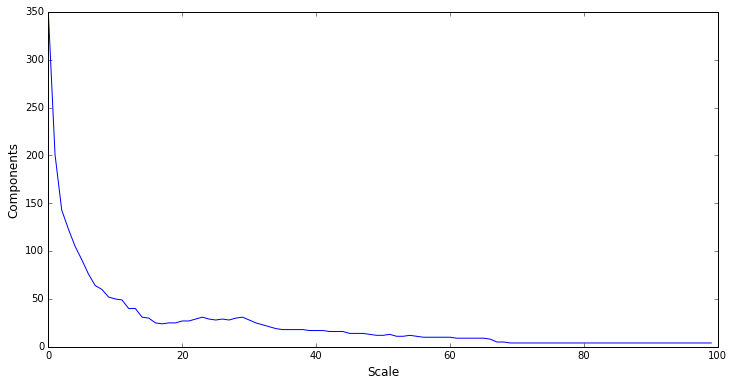

In [5]:
cnet.plot_components(components)
plt.show()

## График уровня $\beta$ в зависимости от масштаба $k$

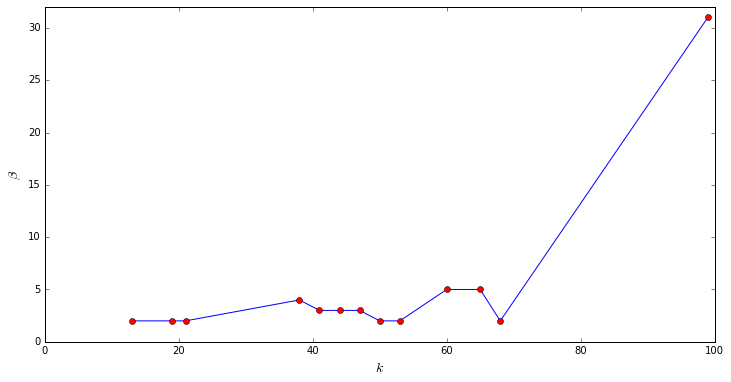

In [6]:
cnet.plot_betas(beta_scales, betas)
plt.show()

# Экстремумы (особые точки) $L_k$ для $\beta$-устойчивых масштабов

Т.к. масштаб $\beta$-устойчивый, то в пределах этого значения число экстремумов не должно меняться, поэтому особые точки можно искать в одном слое.

Для примера, считаем экстремумы для одного масштаба.

In [7]:
s_idx = cnet.select_level(5, betas)
s = beta_scales[s_idx]
print('Selected: (scale, beta) = (%d, %d)' % (s, betas[s_idx]))
lap = log[s]
minima, maxima = cnet.cpt_keypoints(lap, replace_clusters=True)
print('Minima: %d, maxima: %d' % (len(minima), len(maxima)))

Selected: (scale, beta) = (60, 5)
Minima: 26, maxima: 17


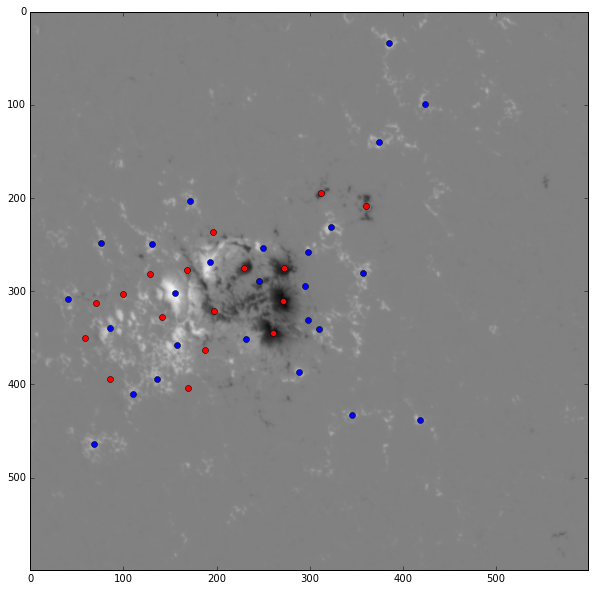

In [8]:
cnet.plot_keypoints(img, minima, maxima)
plt.show()

Красным точкам соответствуют максимумы, а синим минимумы.

# Критическая сеть для выбранного масштаба

In [9]:
edges = cnet.cpt_criticalnet(lap, minima, maxima)
print('Edges: %d' % len(edges))

Edges: 56


Точки не инцидентные ни одному ребру не будут отображаться.

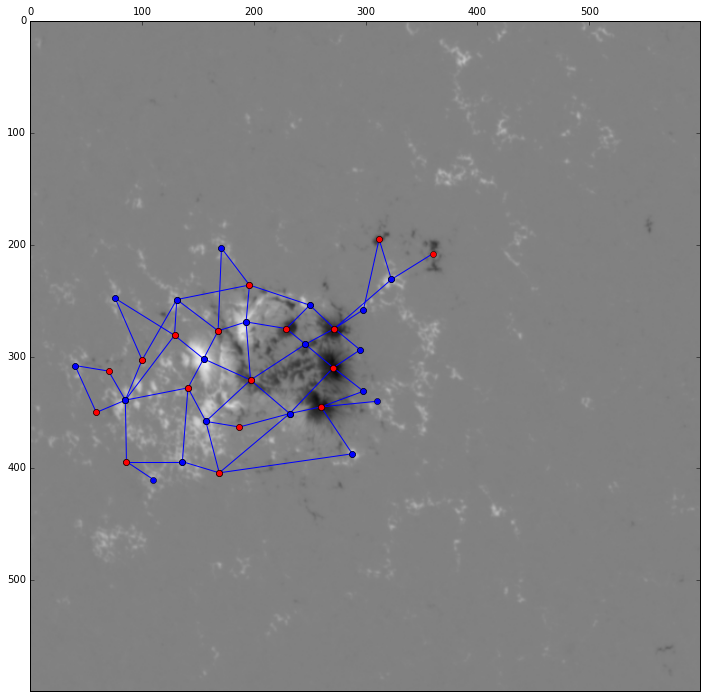

In [10]:
cnet.plot_criticalnet(img, edges)
plt.show()

# Спектр критической сети

In [11]:
spectra = cnet.cpt_spectra(edges)
if spectra is not None:
    print(sorted(spectra))
    print('Min eigenvalue: %g' % spectra.min())
    print('Max eigenvalue: %g' % spectra.max())

[-4.1172519558667223e-15, 0.16743072292378067, 0.28021093823749776, 0.4265609358360688, 0.51653816835525668, 0.76368093500083289, 0.83896868116337531, 0.94671483403860512, 1.0828385474621438, 1.4188889322290834, 1.5535246263992377, 1.697516741719125, 1.8411177262957776, 1.9999999999999996, 2.2344822388568413, 2.5900793509027071, 2.6536390599523614, 2.8956778259388831, 3.0323312507376996, 3.2231326925356414, 3.3540949636524635, 3.5281969786810308, 3.631535909329394, 3.8302877290899873, 4.0354671701558571, 4.2083572476694435, 4.3261911742515542, 4.6805877998680767, 4.7295853599561637, 5.292625358101259, 5.4887092293697659, 5.8870295881694386, 6.5370840837195754, 6.7896390098287869, 7.5207389042968957, 7.9965352852753862]
Min eigenvalue: -4.11725e-15
Max eigenvalue: 7.99654
